In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [51]:
data = pd.read_csv('customer_data.csv');
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [52]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [53]:
df_null = round(100*(data.isnull().sum())/len(data), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [54]:
data = data.dropna()
data['CustomerID'] = data['CustomerID'].astype(str)

In [55]:
#Monetary

data['Amount'] = data['Quantity']*data['UnitPrice']
mt_rfm = data.groupby('CustomerID')['Amount'].sum()
mt_rfm = mt_rfm.reset_index()
mt_rfm.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [56]:
#Frequency

f_rfm = data.groupby('CustomerID')['InvoiceNo'].count()
f_rfm = f_rfm.reset_index()
f_rfm.columns = ['CustomerID','Frequency']
f_rfm.head()


,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [57]:
#Merge the two dataframes (df) of Monetary and Frequency
rfm = pd.merge(mt_rfm, f_rfm , on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [58]:
#Recency
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

date_max = max(data['InvoiceDate'])
date_max

Timestamp('2011-12-09 12:50:00')

In [59]:
data['Difference'] = date_max - data['InvoiceDate']
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [60]:
r_rfm = data.groupby('CustomerID')['Difference'].min()
r_rfm = r_rfm.reset_index()
r_rfm.head()

r_rfm['Difference'] = r_rfm['Difference'].dt.days
r_rfm.head()

,CustomerID,Difference
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [61]:
rfm = pd.merge(rfm, r_rfm, on='CustomerID', how='inner')
rfm.columns = ['CustomerID' , 'Amount' , 'Frequency' , 'Recency']
rfm.head()


,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

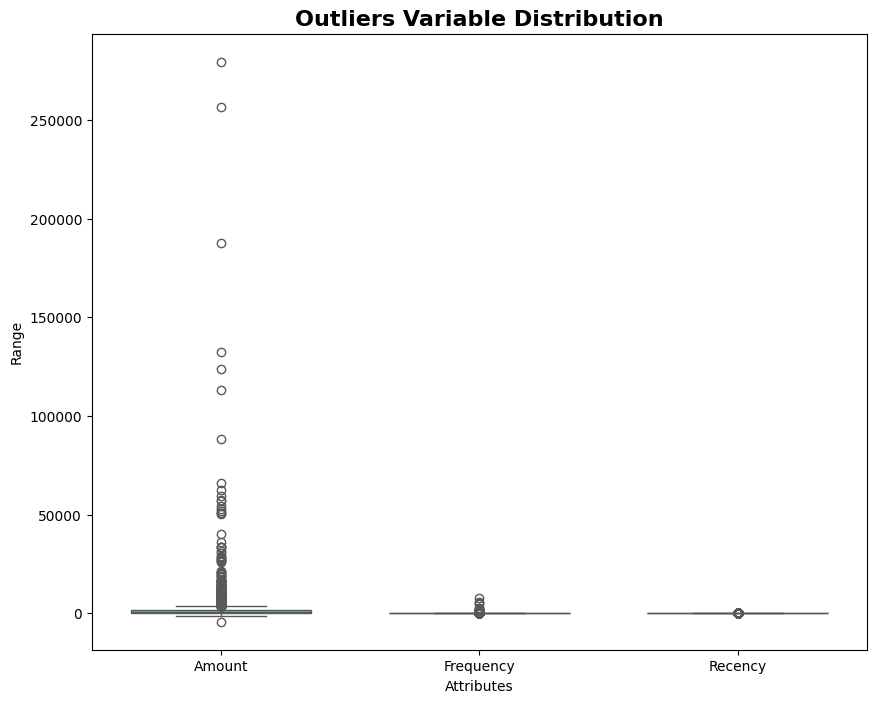

In [62]:
attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 16, fontweight = 'bold')
plt.ylabel("Range") 
plt.xlabel("Attributes")

In [63]:
# Removing outliers

#Amount
Q1 = rfm.Amount.quantile(0.05)
Q2 = rfm.Amount.quantile(0.95)

IQR = Q2 - Q1
rfm= rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q2 + 1.5*IQR)]

#Recency
Q1 = rfm.Recency.quantile(0.05)
Q2 = rfm.Recency.quantile(0.95)

IQR = Q2 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q2 + 1.5*IQR)]

#Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q2 = rfm.Frequency.quantile(0.95)

IQR = Q2 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q2 + 1.5*IQR)]

In [64]:
#Scaling of the Features

df_rfm = rfm[['Amount','Frequency','Recency']]

scaler = StandardScaler()

#Fit Transform
df_rfm_scaled = scaler.fit_transform(df_rfm)
df_rfm_scaled.shape


(4293, 3)

In [65]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled)
df_rfm_scaled.columns = ['Amount', 'Frequency', 'Recency']

In [66]:
#MODEL BUILDING
#k-means

kmeans = KMeans(n_clusters = 4, max_iter = 50)
kmeans.fit(df_rfm_scaled)

kmeans.labels_
set(kmeans.labels_)

{0, 1, 2, 3}

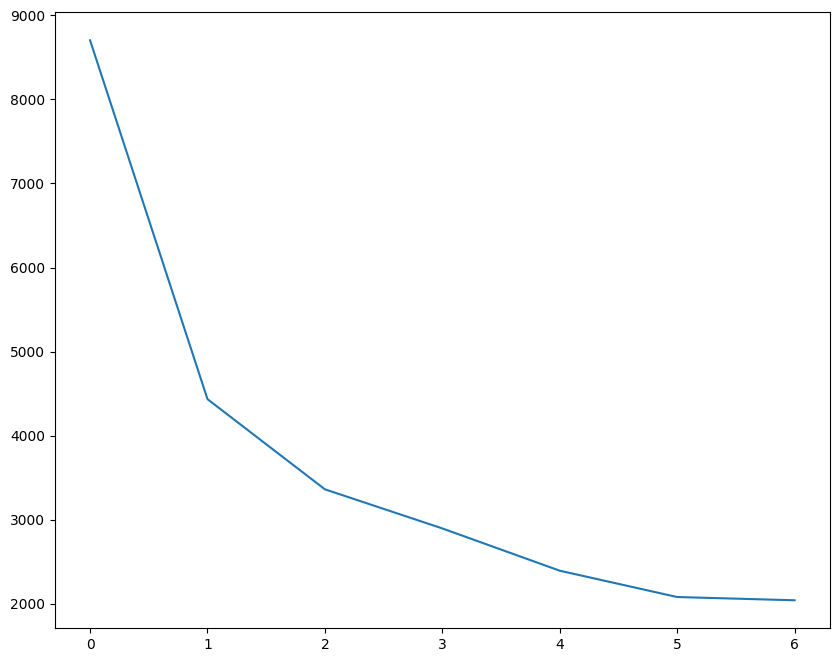

In [67]:
sd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters: 
    kmeans = KMeans(n_clusters = num_clusters, max_iter=50) 
    kmeans.fit(df_rfm_scaled)

    sd.append(kmeans.inertia_)

# plot the SDs for each n_clusters 
plt.plot(sd)


In [68]:
kmeans = KMeans(n_clusters = 3, max_iter = 300)
kmeans.fit(df_rfm_scaled)


KMeans(n_clusters=3)

In [69]:
kmeans.labels_

rfm['Cluster_Id'] = kmeans.labels_
rfm.head()


,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


In [70]:


# Function to get customer information
def get_customer_info(customer_id):
    # Filter data for the given customer ID
    customer_data = data[data['CustomerID'] == customer_id]

    if len(customer_data) == 0:
        return "CustomerID not found!", None, None, None, None

    # Get the country, amount, frequency, and description for the customer
    country = customer_data['Country'].iloc[0]
    amount = customer_data['Amount'].sum()
    frequency = customer_data['InvoiceNo'].nunique()
    description = customer_data['Description'].tolist()

    return "CustomerID found!", country, amount, frequency, description

# Input customerID
customer_id = input("Enter CustomerID: ")

# Get customer information
message, country, amount, frequency, description = get_customer_info(customer_id)

# Display customer information
print(message)
if message == "CustomerID found!":
    print(f"Country: {country}")
    print(f"Total Amount: ${amount:.2f}")
    print(f"Frequency of Purchases: {frequency}")
    print("Description:")
    for item in description:
        print("-", item)


Enter CustomerID:  15


CustomerID not found!


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

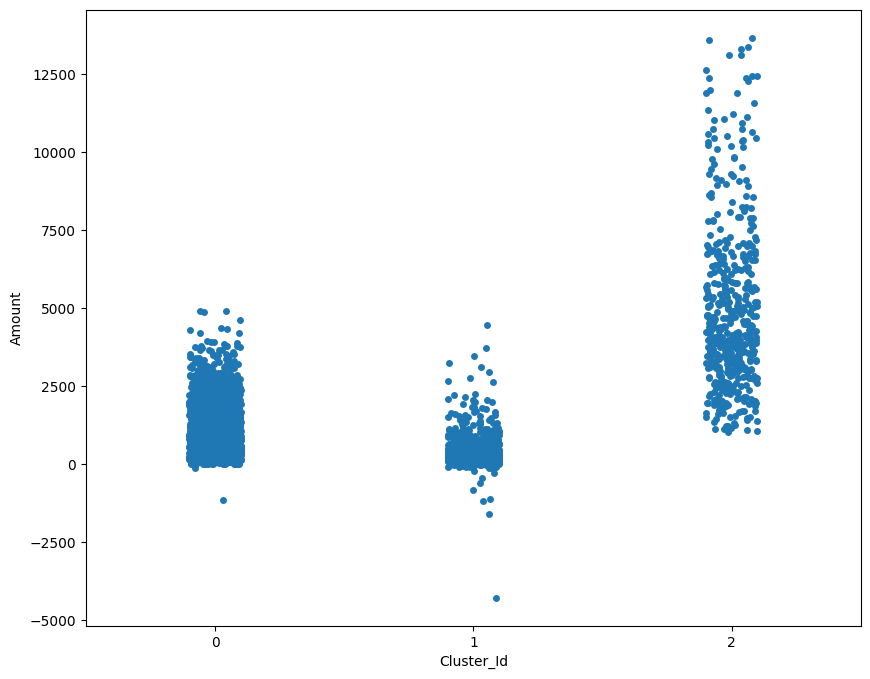

In [71]:
sns.stripplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

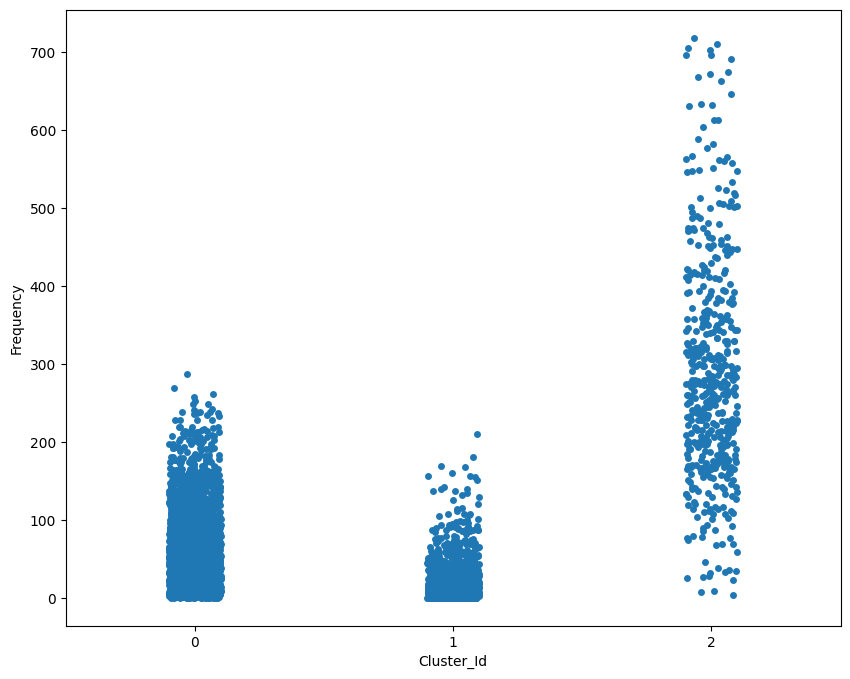

In [72]:
sns.stripplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

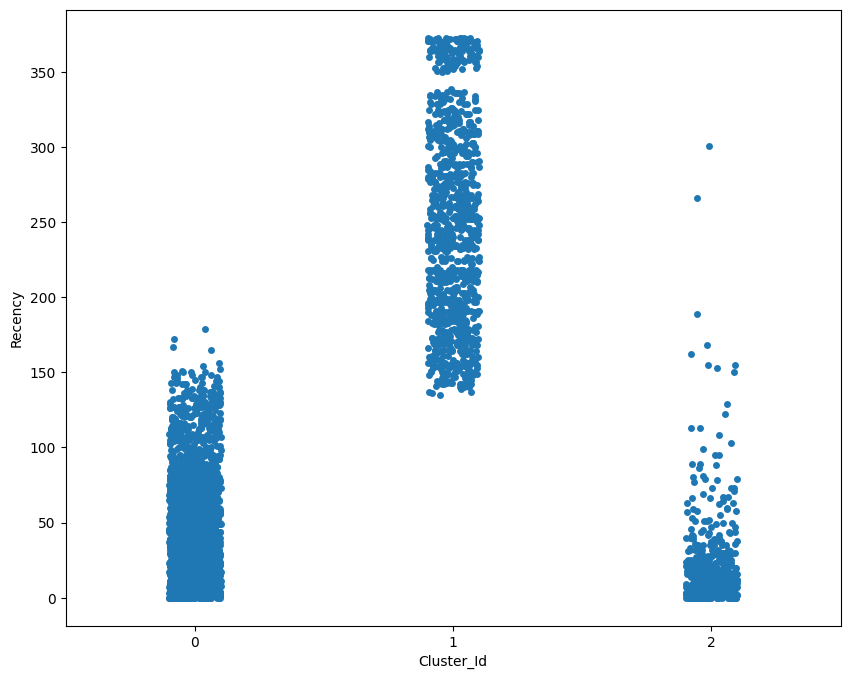

In [73]:
sns.stripplot(x='Cluster_Id', y='Recency', data=rfm)

In [74]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk


# Load data
data = pd.read_csv('customer_data.csv')

# Function to perform RFM analysis
# Function to perform RFM analysis
def perform_rfm_analysis():
    global data
    global rfm
    
    # Compute monetary
    data['Amount'] = data['Quantity'] * data['UnitPrice']
    mt_rfm = data.groupby('CustomerID')['Amount'].sum().reset_index()

    # Compute frequency
    f_rfm = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
    f_rfm.columns = ['CustomerID', 'Frequency']

    # Compute recency
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    date_max = max(data['InvoiceDate'])
    data['Difference'] = date_max - data['InvoiceDate']
    r_rfm = data.groupby('CustomerID')['Difference'].min().reset_index()
    r_rfm['Difference'] = r_rfm['Difference'].dt.days

    # Merge RFM data
    rfm = pd.merge(mt_rfm, f_rfm, on='CustomerID', how='inner')
    rfm = pd.merge(rfm, r_rfm, on='CustomerID', how='inner')
    rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']

    # Display success message
    messagebox.showinfo("RFM Analysis", "RFM analysis has been performed successfully!")




In [75]:
# Function to display RFM results on GUI
def display_rfm_results():
    global rfm

    # Create a new Tkinter window for displaying RFM results
    rfm_window = tk.Toplevel()
    rfm_window.title("RFM Results")

    # Create a treeview to display RFM data
    rfm_tree = ttk.Treeview(rfm_window)
    rfm_tree["columns"] = ("Amount", "Frequency", "Recency")
    rfm_tree.heading("#0", text="CustomerID")
    rfm_tree.heading("Amount", text="Amount")
    rfm_tree.heading("Frequency", text="Frequency")
    rfm_tree.heading("Recency", text="Recency")

    # Insert RFM data into the treeview
    for index, row in rfm.iterrows():
        rfm_tree.insert("", "end", text=row['CustomerID'], values=(row['Amount'], row['Frequency'], row['Recency']))

    # Pack the treeview
    rfm_tree.pack(expand=True, fill="both")

    # Display success message
    messagebox.showinfo("RFM Results", "RFM results have been displayed successfully!")


In [76]:
# Function to perform K-means clustering
def perform_kmeans_clustering():
    global rfm

    # Selecting features for clustering
    features = ['Amount', 'Frequency', 'Recency']
    df_rfm = rfm[features]

    # Scaling the features
    scaler = StandardScaler()
    df_rfm_scaled = scaler.fit_transform(df_rfm)

    # Applying K-means clustering
    kmeans = KMeans(n_clusters=4, max_iter=50)
    kmeans.fit(df_rfm_scaled)

    # Assigning cluster labels
    rfm['Cluster_Id'] = kmeans.labels_

    # Display success message
    messagebox.showinfo("Clustering", "K-means clustering has been performed successfully!")


In [77]:
# Function to display clustering results on GUI
def display_clustering_results():
    global rfm

    # Create a new Tkinter window for displaying clustering results
    clustering_window = tk.Toplevel()
    clustering_window.title("Clustering Results")

    # Create a scatter plot for clustering results
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot clusters
    sns.scatterplot(x='Amount', y='Frequency', hue='Cluster_Id', data=rfm, palette='Set1', ax=ax)

    # Set plot title and labels
    plt.title('Clustering Results')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')

    # Embedding the plot in the GUI
    canvas = FigureCanvasTkAgg(fig, master=clustering_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    # Display success message
    messagebox.showinfo("Clustering Results", "Clustering results have been displayed successfully!")

In [78]:
# Function to search for CustomerID in RFM analysis
def search_customer():
    customer_id = search_entry.get()
    if customer_id.strip() == "":
        messagebox.showerror("Error", "Please enter a CustomerID!")
        return

    # Check if CustomerID exists in the dataset
    if customer_id not in data['CustomerID'].unique():
        messagebox.showerror("Error", "CustomerID not found!")
        return

    # Perform RFM analysis for the given CustomerID
    last_purchase_date = customer_data['InvoiceDate'].max()
    recency = (pd.Timestamp.now() - last_purchase_date).days

    frequency = customer_data['InvoiceNo'].nunique()

    monetary_value = customer_data['Amount'].sum()

    # Print or return the RFM values
    messagebox.showinfo("RFM Analysis", f"Recency: {recency} days\nFrequency: {frequency}\nMonetary Value: ${monetary_value:.2f}")


In [79]:
def display_customer_info():
    customer_id = customer_id_entry.get()
    customer_data = data[data['CustomerID'] == customer_id]

    if len(customer_data) == 0:
        messagebox.showerror("Error", "CustomerID not found!")
        return

    country = customer_data['Country'].iloc[0]
    amount = customer_data['Amount'].sum()
    frequency = customer_data['InvoiceNo'].nunique()

    messagebox.showinfo("Customer Information", f"Customer Country: {country}\nTotal Amount: ${amount:.2f}\nFrequency of Purchases: {frequency}")

# Function to open a window to input CustomerID
def open_customer_info_window():
    global customer_id_entry

    # Create a new Tkinter window for inputting CustomerID
    customer_info_window = tk.Toplevel()
    customer_info_window.title("Customer Information")

    # Label and Entry for CustomerID input
    ttk.Label(customer_info_window, text="Enter CustomerID:").pack()
    customer_id_entry = ttk.Entry(customer_info_window)
    customer_id_entry.pack()

    # Button to display customer information
    display_button = ttk.Button(customer_info_window, text="Display Info", command=display_customer_info)
    display_button.pack()

In [82]:
# Create Tkinter window
root = tk.Tk()
root.title("Customer Segmentation Analysis")

root.geometry("800x600")

background_image = Image.open("bgimage.jpg")
background_photo = ImageTk.PhotoImage(background_image)

# Create a label with the background image
background_label = tk.Label(root, image=background_photo)
background_label.place(x=0, y=0, relwidth=1, relheight=1)

#Text at the top of the window
title_label = ttk.Label(root, text="Customer Segmentation Analysis", font=("Helvetica", 16, "bold"))
title_label.pack(side="top", fill="x")

# Create a frame to contain the buttons
button_frame = ttk.Frame(root)
button_frame.pack(side="left", padx=20, pady=20)

button_font = ('Helvetica', 12)
style = ttk.Style()
style.configure('Custom.TButton', font=button_font)

# Frame for RFM analysis
rfm_frame = ttk.Frame(root)
rfm_frame.pack(padx=10, pady=10)
# Search bar for CustomerID
search_label = ttk.Label(rfm_frame, text="Enter CustomerID:")
search_label.grid(row=0, column=0, padx=5, pady=5, sticky="e")

search_entry = ttk.Entry(rfm_frame, width=20)
search_entry.grid(row=0, column=1, padx=5, pady=5)

search_button = ttk.Button(rfm_frame, text="Search", command=search_customer)
search_button.grid(row=0, column=2, padx=5, pady=5)

# Button to perform RFM analysis
rfm_button = ttk.Button(button_frame, text="Perform RFM Analysis", command=perform_rfm_analysis,width=30 , style='Custom.TButton')
rfm_button.pack(fill="x", pady=5)

# Button to display RFM results
rfm_results_button = ttk.Button(button_frame, text="Display RFM Results", command=display_rfm_results, width=30, style='Custom.TButton')
rfm_results_button.pack(fill="x", pady=5)

# Button to perform K-means clustering
clustering_button = ttk.Button(button_frame, text="Perform Clustering", command=perform_kmeans_clustering, width=30, style='Custom.TButton')
clustering_button.pack(fill="x", pady=5)

# Button to display clustering results
clustering_results_button = ttk.Button(button_frame, text="Display Clustering Results", command=display_clustering_results, width=30, style='Custom.TButton')
clustering_results_button.pack(fill="x", pady=5)

# Button to open Customer Information window
customer_info_button = ttk.Button(button_frame, text="Customer Information", command=open_customer_info_window, width=30, style='Custom.TButton')
customer_info_button.pack(fill="x", pady=5)

# Run the Tkinter event loop
root.mainloop()
